## Data Unzip

In [1]:
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torchaudio
import IPython.display as ipd
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
from glob import glob

import pretty_midi
pretty_midi.pretty_midi.MAX_TICK = 1e10

torch.set_printoptions(sci_mode=False)

In [2]:
maps_path = Path('/Users/idasol/Desktop/Visual_Studio_Projects/onsets_and_frames/maps')

# UNZIP
maps_piano_path = list(maps_path.rglob('*_2.zip'))
# for path in maps_piano_path:
#     zipfile.ZipFile(path).extractall(maps_path)

In [3]:
def time2frame(time, hop_length=512):
    return round(time / (hop_length / 1000))

In [4]:
class MAPSDataset:
    def __init__(self, dir_path, split, sr=16000):
        self.sr = sr
        self.hop_length = 512
        self.dir_path = list(dir_path.glob('./*/*/'))
        self.frame_per_sec =  self.sr/self.hop_length

        # split train, test set
        train_folder = ['AkPnBcht', 'AkPnBsdf', 'AkPnCGdD', 'AkPnStgb', 'SptkBGAm', 'SptkBGCl', 'StbgTGd2']
        test_folder = ['ENSTDkAm', 'ENSTDkCl']
        self.target_folder = train_folder if split=='train' else test_folder

        self._load_data()

    def get_piano_roll(self, path):
        # make label - total
        midi = pretty_midi.PrettyMIDI(midi_file=path)
        total = midi.get_piano_roll(fs=self.frame_per_sec, times=None, pedal_threshold=64)
        total[total > 0] = 1 # remove velocity
        total = total[21:109]
        # make label - onset
        onset = np.zeros_like(total)
        for note in midi.instruments[0].notes:
            onset[int(note.pitch) - 21, int(note.start * self.frame_per_sec)] = 1
        pianoroll = np.stack([total, onset], axis=0)
        return pianoroll

    def _load_data(self):
        # make lists of wav, midi paths
        self.audio = []
        self.roll = []
        for path in self.dir_path:
            folder = path.parent.name
            wav_files = list(path.rglob('*.wav'))
            missing_list = []

            if folder in self.target_folder:
                for file in wav_files:
                    midi = file.with_suffix('.mid')
                    if not midi.exists():
                        missing_list.append(id)
                        continue
                    roll = self.get_piano_roll(str(midi))
                    self.audio.append(file)
                    self.roll.append(roll)
        print(missing_list)

    def __len__(self):
        return len(self.audio)
        
    # def __getitem__(self, idx):
    #     audio, sr = torchaudio.load(self.audio[idx])
    #     audio = torchaudio.functional.resample(audio, sr, self.sr)
    #     roll = self.roll[idx]
    #     start = random.randint(0, len(audio[0]) - (self.sr * 25) - 1)
    #     end = start + (self.sr * 20)
    #     sliced_audio = audio[:, start:end].mean(dim=0) # stereo to mono

    #     start_roll = time2frame(start/self.sr)
    #     end_roll = start_roll + int(20 * self.sr/512)
    #     sliced_roll = roll[:, :, start_roll:end_roll]
    #     return sliced_audio, sliced_roll

    def __getitem__(self, idx):
        roll = self.roll[idx]        
        start = random.randint(0, len(roll[0][0]) - int((self.sr * 25) / 512) - 1) # 이 부분 체크
        end = int(start + ((self.sr * 20) / 512))     
        sliced_roll = roll[:, :, start:end]

        audio, sr = torchaudio.load(self.audio[idx])
        audio = torchaudio.functional.resample(audio, sr, self.sr)
        start_audio = start * self.hop_length # 체크..
        end_audio = start_audio + (20 * self.sr)
        sliced_audio = audio[:, start_audio:end_audio].mean(dim=0) # stereo to mono

        return sliced_audio, sliced_roll

In [5]:
trainset = MAPSDataset(maps_path, 'train')
testset = MAPSDataset(maps_path, 'test')

UnboundLocalError: local variable 'missing_list' referenced before assignment

In [132]:
train_loader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=0)
test_loader = DataLoader(testset, batch_size=10, num_workers=0)
batch = next(iter(train_loader))

In [133]:
batch[0].shape, batch[1].shape

(torch.Size([8, 320000]), torch.Size([8, 2, 88, 625]))

#### Label끼리 잘 맞나 확인

In [134]:
def check_label(split: str, idx, slice: int):
    if split == 'train':
        label = trainset.roll[idx]
    elif split == 'test':
        label = testset.roll[idx]
    plt.figure(figsize=(15, 7))
    plt.imshow((label[0] + label[1])[:, :slice], aspect='auto', interpolation='nearest', origin='lower')

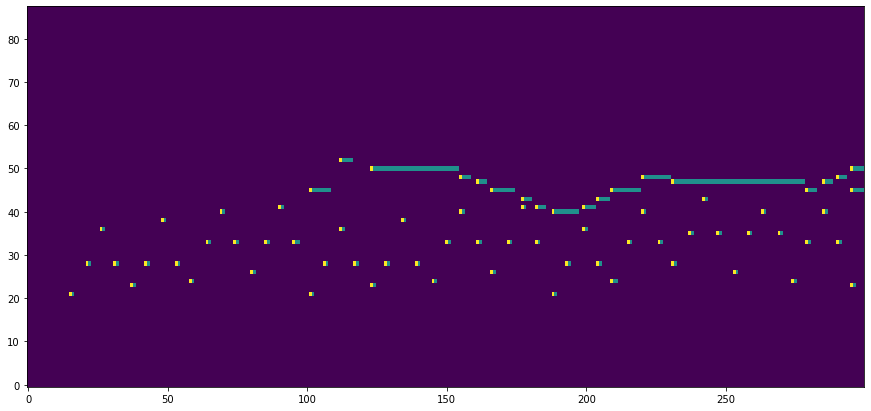

In [135]:
check_label('train', 17, 300)

#### audio-label끼리 잘 맞나 확인

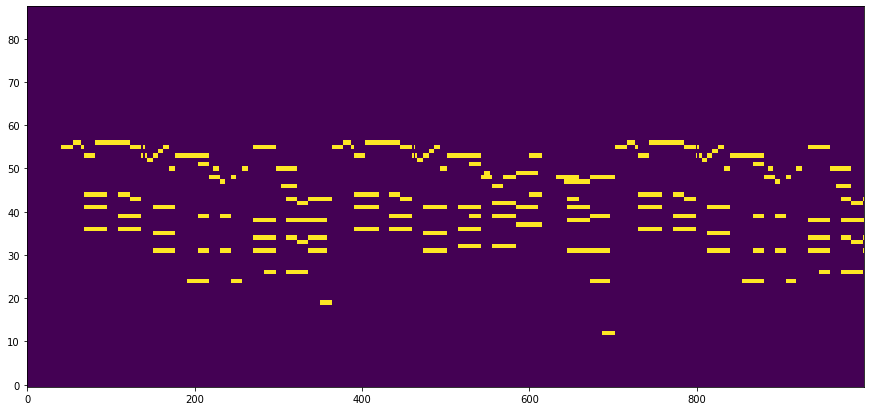

In [136]:
plt.figure(figsize=(15, 7))
plt.imshow(trainset.roll[0][0][:, :1000], aspect='auto', interpolation='nearest', origin='lower')

In [137]:
audio, label = trainset[1]

In [138]:
audio = audio.view([1, -1])
audio.shape

torch.Size([1, 320000])

In [139]:
torchaudio.save(filepath='/Users/idasol/Desktop/Visual Studio Projects/onsets_and_frames/audio_samples/sample5.wav', src= audio, sample_rate=16000)

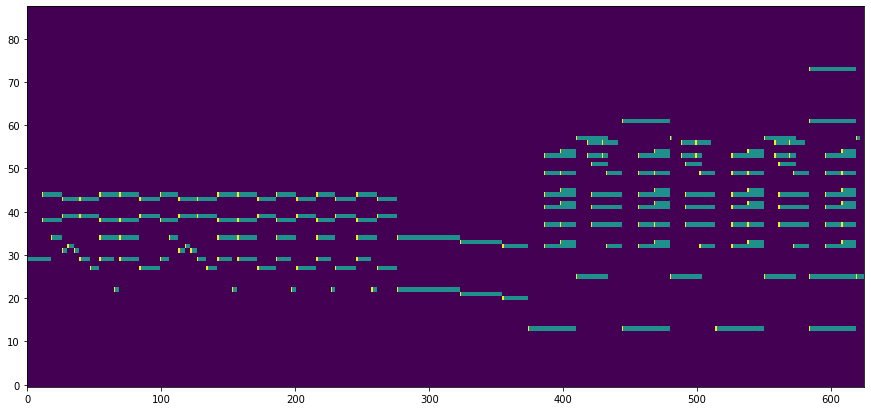

In [145]:
plt.figure(figsize=(15, 7))
plt.imshow(label[0] + label[1], aspect='auto', interpolation='nearest', origin='lower')

## Model

In [141]:
def pitch2hz(pitch):
    return 2 ** ((pitch-69) / 12) * 440

In [142]:
class BaselineModel(nn.Module):
    def __init__(self, hidden_size=256):
        super().__init__()
        
        self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=16000,
                                                                n_fft = 2048,
                                                                hop_length = 512,
                                                                f_min = 20,
                                                                f_max = 8000,
                                                                n_mels = 88 * 4,
                                                            )
        self.rnn = nn.GRU(88*4, hidden_size, num_layers=4, bidirectional=True, batch_first=True)
        self.projection = nn.Linear(hidden_size * 2, 88)

    def forward(self, x):
        mel_spec = self.mel_converter(x) # batch size x num mels x time
        hidden_out, last_hidden = self.rnn(mel_spec.permute(0, 2, 1))
        logit = self.projection(hidden_out)
        prob = torch.sigmoid(logit)
        return prob.permute(0, 2, 1) # pianoroll 형식으로 변환

model = BaselineModel()
out = model(batch[0])
out.shape, batch[1].shape

(torch.Size([8, 88, 626]), torch.Size([8, 2, 88, 625]))

In [143]:
def get_binary_cross_entropy_loss(pred, target, eps=1e-7):
    return -(target * torch.log(pred+eps) + (1-target) * torch.log((1-pred)+eps)).mean()

get_binary_cross_entropy_loss(out[..., :-1], batch[1][0, 0])

tensor(0.6976, dtype=torch.float64, grad_fn=<NegBackward0>)

In [144]:
model = BaselineModel()
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 5
loss_record = []
test_record = []
model.train()

for epoch in  tqdm(range(num_epochs)):
    for batch in tqdm(train_loader, leave=False):
        audio, roll = batch
        out = model(audio)
        loss = get_binary_cross_entropy_loss(out[..., :-1], roll[0, 0])
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        loss_record.append(loss.item())
    model.eval()
    with torch.no_grad():
        epoch_loss = 0
        for batch in test_loader:
            audio, roll = batch
            out = model(audio)
            loss = get_binary_cross_entropy_loss(out[..., :-1], roll[0, 0])
            # test_record.append(loss.item())
            epoch_loss += loss.item()
        test_record.append(epoch_loss / len(test_loader))
    model.train()


  0%|          | 0/5 [00:19<?, ?it/s]


ValueError: empty range for randrange() (0, -38, -38)

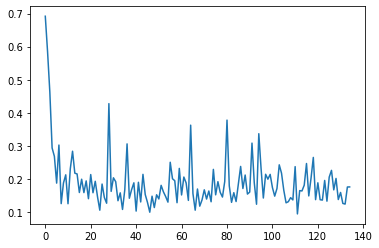

In [ ]:
plt.plot(loss_record)

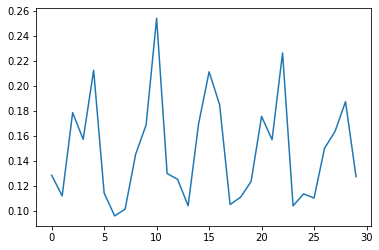

In [ ]:
plt.plot(test_record)

In [ ]:
class CNNModel(BaselineModel):
    def __init__(self, hidden_size=256):
        super().__init__(hidden_size)
        self.cnn = nn.Sequential(nn.Conv2d(1, hidden_size//4, kernel_size=(3, 3), padding=1),
                                 nn.BatchNorm2d(hidden_size//4),
                                 nn.MaxPool2d((2, 1)),
                                 nn.ReLU(),
                                 
                                 nn.Conv2d(hidden_size//4, hidden_size//2, kernel_size=(3, 3), padding=1),
                                 nn.BatchNorm2d(hidden_size//2),
                                 nn.MaxPool2d((2, 1)),
                                 nn.ReLU(),
                                 
                                 nn.Conv2d(hidden_size//2, hidden_size, kernel_size=(3, 3), padding=1),
                                 nn.BatchNorm2d(hidden_size),
                                 nn.ReLU(),)
                                 
        self.fc = nn.Linear(88 * hidden_size, hidden_size) 
        self.rnn = nn.GRU(hidden_size, hidden_size, num_layers=3, bidirectional=True, batch_first=True)

    def forward(self, x):
        mel_spec = self.mel_converter(x) # batch size x num mels x time
        mel_spec = mel_spec.unsqueeze(1)
        conv_out = self.cnn(mel_spec)
        conv_out = conv_out.reshape(x.shape[0], -1, mel_spec.shape[-1])
        fc_out = self.fc(conv_out.permute(0, 2, 1))
        hidden_out, last_hidden = self.rnn(fc_out)
        logit = self.projection(hidden_out)
        prob = torch.sigmoid(logit)
        return prob.permute(0, 2, 1) # pianoroll 형식으로 변환

In [ ]:
model = CNNModel()
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 5
loss_record = []
test_record = []
model.train()

for epoch in  tqdm(range(num_epochs)):
    for batch in tqdm(train_loader, leave=False):
        audio, roll = batch
        out = model(audio)
        loss = get_binary_cross_entropy_loss(out[..., :-1], roll[0, 0])
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        loss_record.append(loss.item())
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            audio, roll = batch
            out = model(audio)
            loss = get_binary_cross_entropy_loss(out[..., :-1], roll[0, 0])
            test_record.append(loss.item())
    model.train()

100%|██████████| 5/5 [14:13<00:00, 170.63s/it]


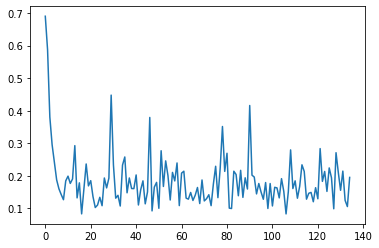

In [ ]:
plt.plot(loss_record)

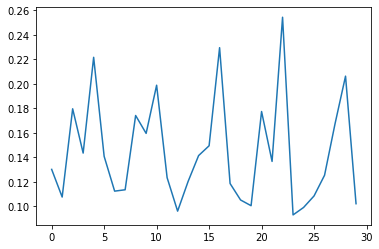

In [ ]:
plt.plot(test_record)

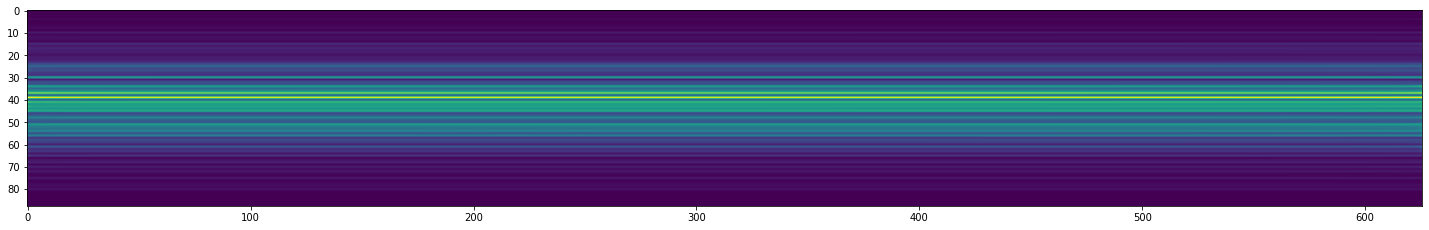

In [ ]:
plt.figure(figsize=(25, 7))
plt.imshow(out[2])

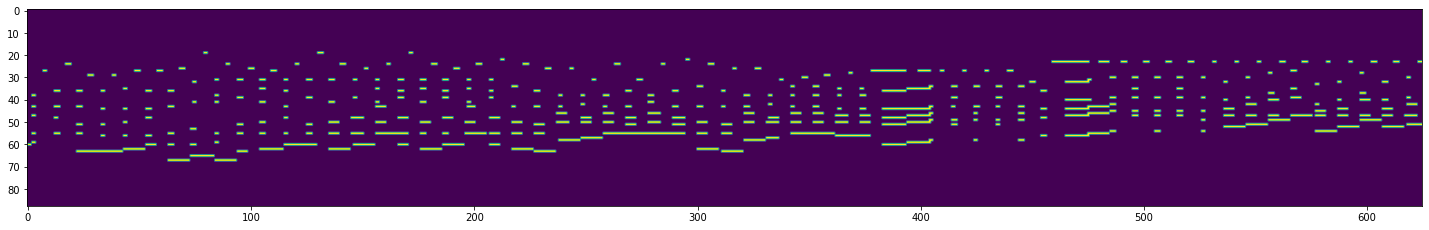

In [ ]:
plt.figure(figsize=(25, 7))
plt.imshow(roll[2][0])

In [ ]:
class CNNwithLSTMModel(BaselineModel):
    def __init__(self, hidden_size=256):
        super().__init__(hidden_size)
        self.cnn = nn.Sequential(nn.Conv2d(1, hidden_size//4, kernel_size=(3, 3), padding=1),
                                 nn.BatchNorm2d(hidden_size//4),
                                 nn.MaxPool2d((2, 1)),
                                 nn.ReLU(),
                                 
                                 nn.Conv2d(hidden_size//4, hidden_size//2, kernel_size=(3, 3), padding=1),
                                 nn.BatchNorm2d(hidden_size//2),
                                 nn.MaxPool2d((2, 1)),
                                 nn.ReLU(),
                                 
                                 nn.Conv2d(hidden_size//2, hidden_size, kernel_size=(3, 3), padding=1),
                                 nn.BatchNorm2d(hidden_size),
                                 nn.ReLU(),)
                                 
        self.fc = nn.Linear(88 * hidden_size, hidden_size) 
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=3, bidirectional=True, batch_first=True)

    def forward(self, x):
        mel_spec = self.mel_converter(x) # batch size x num mels x time
        mel_spec = mel_spec.unsqueeze(1)
        conv_out = self.cnn(mel_spec)
        conv_out = conv_out.reshape(x.shape[0], -1, mel_spec.shape[-1])
        fc_out = self.fc(conv_out.permute(0, 2, 1))
        hidden_out, last_hidden = self.lstm(fc_out)
        logit = self.projection(hidden_out)
        prob = torch.sigmoid(logit)
        return prob.permute(0, 2, 1) # pianoroll 형식으로 변환

In [ ]:
model = CNNwithLSTMModel()
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 5
loss_record = []
test_record = []
model.train()

for epoch in  tqdm(range(num_epochs)):
    for batch in tqdm(train_loader, leave=False):
        audio, roll = batch
        out = model(audio)
        loss = get_binary_cross_entropy_loss(out[..., :-1], roll[0, 0])
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        loss_record.append(loss.item())
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            audio, roll = batch
            out = model(audio)
            loss = get_binary_cross_entropy_loss(out[..., :-1], roll[0, 0])
            test_record.append(loss.item())
    model.train()

100%|██████████| 5/5 [15:46<00:00, 189.23s/it]


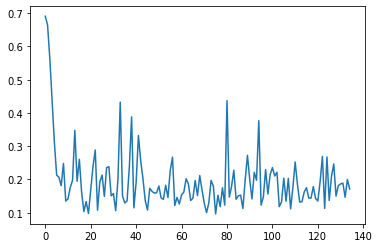

In [ ]:
plt.plot(loss_record)

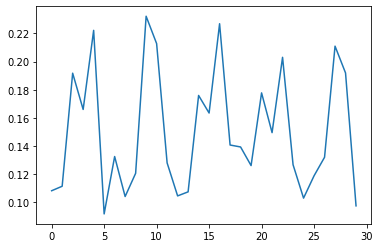

In [ ]:
plt.plot(test_record)